# Descriptive Analysis and Predictive Modelling

### Introduction:

This notebook contains code for an analysis/modelling exercise. 

#### Data:
For this exercise, the author chose a freely available financial data set available [here](http://lisp.vse.cz/pkdd99/berka.htm). The link contains detailed description of the data set. Briefly, the set contains information on clients, accounts, loans, transactions, credit cards, demographics etc. The original purpose of this data set was to challenge users to identify "good" and "bad" clients. In this notebook, the author pursues this  Good/Bad classification exercise, based, however, on AML specific metrics.

#### Method:
##### Demographic Data:
First the demographics data is analyzed. This table/relation provides information on inhabitants, average income, region, number of crimes in 95 and 96, the overall population, unemployment rates, etc. In the AML world, there are several instances when the domicile locality of the customer or the account is used to score their AML risk. For example any client in Locale A is scored as "High Risk", whereas those in Locale B is scored "Low Risk". 

For this exercise, the author chose crime rates in 1996, i.e no. of crimes per 1000 inhabitants as the metric to decide between Good and Bad districts.

##### Loan Data:
The available loan data has specific indicators which indicate whether a loan is open or closed and whether it is in a good or a bad state. This indicator was used to determine whether an account is either Good or Bad

##### Cash and Wire Transactions:
In the AML domain, high value/high volume cash and wire transactions are traditionally considered indicators of potential Money Laundering activity. As such, there are dedicated monitors and controls on such activities in all Financial Institutions. 

In this exercise, the author marked accounts related to cash or wire transactions over 50,000 in value to be Good or Bad.

##### Predictive Modelling:
Once the Good and Bad clients were identified, the author used the loan, demographic, and transaction features to train Support Vector and Decision Tree Classfiers. The performance of these will be discussed in the conclusion.

*In the rest of the notebook, data import, exploratory analysis, predictive modelling are performed. There are some graphs and tables which offer insight into the data and help with decisions on model parameter selection*

### Data Import & Preparation:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
account = pd.read_csv('Berka/account.asc',sep=';',encoding='ascii')
card = pd.read_csv('Berka/card.asc',sep=';',encoding='ascii')
client = pd.read_csv('Berka/client.asc',sep=';',encoding='ascii',dtype={'birth_number':object})
disp = pd.read_csv('Berka/disp.asc',sep=';',encoding='ascii')
district = pd.read_csv('Berka/district.asc',sep=';',encoding='ascii',na_values='?')
loan = pd.read_csv('Berka/loan.asc',sep=';',encoding='ascii')
order = pd.read_csv('Berka/order.asc',sep=';',encoding='ascii',dtype={'k_symbol':object})
trans = pd.read_csv('Berka/trans.asc',sep=';',encoding='ascii',\
                    dtype={'date':object,'k_symbol':object,'bank':object,'account':object})

#parse_dates=['date'], infer_datetime_format=True,\

In [3]:
account.loc[:,'date']=pd.to_datetime(account['date'],format='%y%m%d').map(lambda x: datetime(x.year-100,x.month,x.day) if x>=datetime(2000,1,1) else x)
trans.loc[:,'date']=pd.to_datetime(trans['date'],format='%y%m%d').map(lambda x: datetime(x.year-100,x.month,x.day) if x>=datetime(2000,1,1) else x)
loan.loc[:,'date']=pd.to_datetime(loan['date'],format='%y%m%d').map(lambda x: datetime(x.year-100,x.month,x.day) if x>=datetime(2000,1,1) else x)

In [4]:
client['sex']=client['birth_number'].map(lambda x:'F' if int(x[2:4])>12 else 'M', na_action='ignore')

#client['sex']=client['birth_number'].map(lambda x:x[2:3], na_action='ignore')

client['birth_date']=pd.to_datetime(client['birth_number'].\
                                    map(lambda x:x[:2]+ '{0:02d}'.format(int(x[2:4])%50)+x[4:], na_action='ignore'),\
                                    format='%y%m%d')

#client.loc[:,'birth_date']=client['birth_date'].map(lambda x: datetime(x.year-100,x.month,x.day) if x>=datetime.now() else x)

client.loc[:,'birth_date']=client['birth_date'].map(lambda x: datetime(x.year-100,x.month,x.day) if x>=datetime(2000,1,1) else x)

### Exploring Demographic Data:

In [5]:
district.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [6]:
demographics=district[['A1','A2','A3','A4','A11','A12','A13','A14','A15','A16']].\
rename(columns={'A1':'district_id',\
                'A2':'dist_name',\
                'A3':'region',\
                'A4':'n_inhabitants',\
                'A11':'avg_salary',\
                'A12':'unemployment_95',\
                'A13':'unemployment_96',\
                'A14':'entrepreneurs_1000',\
                'A15':'n_crime_95',\
                'A16':'n_crime_96'})

In [117]:
demographics.head()

,district_id,dist_name,region,n_inhabitants,avg_salary,unemployment_95,unemployment_96,entrepreneurs_1000,n_crime_95,n_crime_96,crimes_per_1000
0,1,Hl.m. Praha,Prague,1204953,12541,0.29,0.43,167,85677,99107,82.249681
1,2,Benesov,central Bohemia,88884,8507,1.67,1.85,132,2159,2674,30.084155
2,3,Beroun,central Bohemia,75232,8980,1.95,2.21,111,2824,2813,37.391004
3,4,Kladno,central Bohemia,149893,9753,4.64,5.05,109,5244,5892,39.308040
4,5,Kolin,central Bohemia,95616,9307,3.85,4.43,118,2616,3040,31.793842


In [8]:
demographics['n_inhabitants'].describe().round(2)

count         77.00
mean      133884.90
std       136913.46
min        42821.00
25%        85852.00
50%       108871.00
75%       139012.00
max      1204953.00
Name: n_inhabitants, dtype: float64

In [9]:
demographics['unemployment_95'].describe().round(2)

count    76.00
mean      3.12
std       1.67
min       0.29
25%       1.79
50%       2.82
75%       3.89
max       7.34
Name: unemployment_95, dtype: float64

In [10]:
demographics.loc[:,'n_inhabitants':].describe().round(2)

,n_inhabitants,avg_salary,unemployment_95,unemployment_96,entrepreneurs_1000,n_crime_95,n_crime_96
count,77.00,77.00,76.00,77.00,77.00,76.00,77.00
mean,133884.90,9031.68,3.12,3.79,116.13,4850.32,5030.83
std,136913.46,790.20,1.67,1.91,16.61,9888.95,11270.80
min,42821.00,8110.00,0.29,0.43,81.00,818.00,888.00
25%,85852.00,8512.00,1.79,2.31,105.00,2029.75,2122.00
50%,108871.00,8814.00,2.82,3.60,113.00,2932.00,3040.00
75%,139012.00,9317.00,3.89,4.79,126.00,4525.50,4595.00
max,1204953.00,12541.00,7.34,9.40,167.00,85677.00,99107.00


In [11]:
demographics.dtypes

district_id             int64
dist_name              object
region                 object
n_inhabitants           int64
avg_salary              int64
unemployment_95       float64
unemployment_96       float64
entrepreneurs_1000      int64
n_crime_95            float64
n_crime_96              int64
dtype: object

In [12]:
demographics[demographics['n_crime_96']<=5030.83].count()

district_id           62
dist_name             62
region                62
n_inhabitants         62
avg_salary            62
unemployment_95       61
unemployment_96       62
entrepreneurs_1000    62
n_crime_95            61
n_crime_96            62
dtype: int64

##### A Distribution of crimes in 1996:

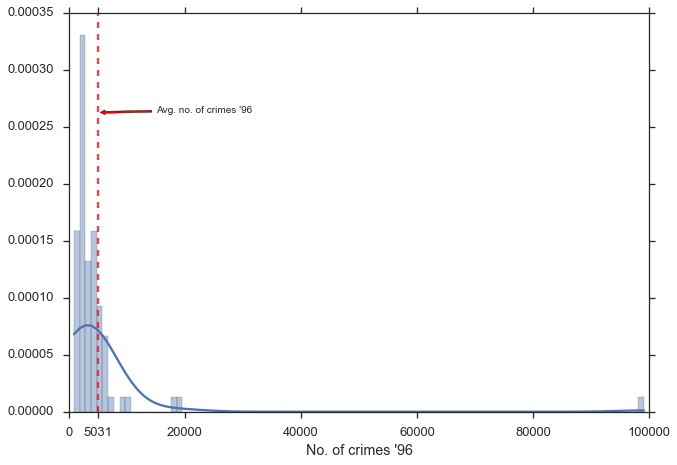

In [13]:
sns.set_context("talk")
sns.set_style('white')
sns.set_style('ticks')
avg_crimes_96=np.mean(demographics['n_crime_96'])
ax = sns.distplot(demographics['n_crime_96'],hist=True,norm_hist=False,kde=True, axlabel="No. of crimes '96",bins=100)
avg_val=ax.axvline(x=avg_crimes_96,alpha=0.75,ls='dashed',label="Avg. no. of crimes '96",c='r')
ax.set_xlim(0,)
ax.set_xticks(list(ax.get_xticks()) + [avg_crimes_96])
#ax.legend(handles=[avg_val])
plt.annotate("Avg. no. of crimes '96",xy=(avg_crimes_96,ax.get_ylim()[1]*0.75),xytext=(avg_crimes_96+10000,ax.get_ylim()[1]*0.75),xycoords='data',
            arrowprops=dict(facecolor='red', arrowstyle='simple'),)
#shrink=0.05,
#plt.show()

In [14]:
high_crime_dist=demographics[demographics['n_crime_96']>=avg_crimes_96]

In [15]:
demographics['crimes_per_1000']=demographics.apply(lambda x: x['n_crime_96']*1000/x['n_inhabitants'],axis=1)

In [16]:
demographics.head()

,district_id,dist_name,region,n_inhabitants,avg_salary,unemployment_95,unemployment_96,entrepreneurs_1000,n_crime_95,n_crime_96,crimes_per_1000
0,1,Hl.m. Praha,Prague,1204953,12541,0.29,0.43,167,85677,99107,82.249681
1,2,Benesov,central Bohemia,88884,8507,1.67,1.85,132,2159,2674,30.084155
2,3,Beroun,central Bohemia,75232,8980,1.95,2.21,111,2824,2813,37.391004
3,4,Kladno,central Bohemia,149893,9753,4.64,5.05,109,5244,5892,39.308040
4,5,Kolin,central Bohemia,95616,9307,3.85,4.43,118,2616,3040,31.793842


##### Distribution of Crime rates in 1996:

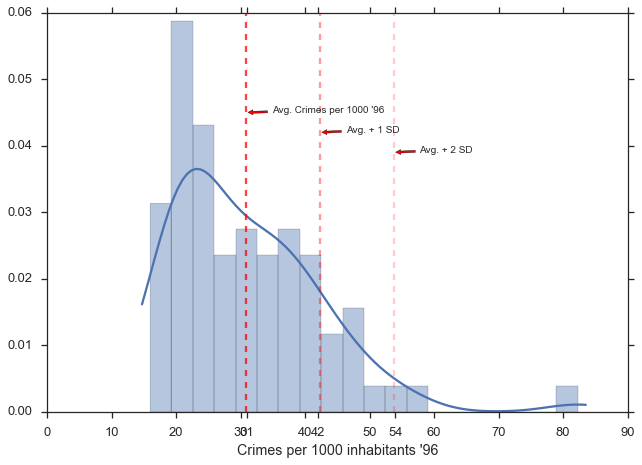

In [17]:
avg_crime_rt_96=np.mean(demographics['crimes_per_1000'])
ax = sns.distplot(demographics['crimes_per_1000'],hist=True,norm_hist=False,kde=True, axlabel="Crimes per 1000 inhabitants '96",bins=20)
avg_val=ax.axvline(x=avg_crime_rt_96,alpha=0.75,ls='dashed',label="Avg. Crimes per 1000 inhabitants '96",c='r')
std_crime_rt_96=np.std(demographics['crimes_per_1000'])
sd1_val=ax.axvline(x=avg_crime_rt_96+std_crime_rt_96,alpha=0.4,ls='dashed',c='r')
sd2_val=ax.axvline(x=avg_crime_rt_96+2*std_crime_rt_96,alpha=0.2,ls='dashed',c='r')
ax.set_xlim(0,)
ax.set_xticks(list(ax.get_xticks()) + [round(avg_crime_rt_96),round(avg_crime_rt_96+std_crime_rt_96),round(avg_crime_rt_96+2*std_crime_rt_96)])
#ax.legend(handles=[avg_val])
plt.annotate("Avg. Crimes per 1000 '96",xy=(avg_crime_rt_96,ax.get_ylim()[1]*0.75),xytext=(avg_crime_rt_96+4,ax.get_ylim()[1]*0.75),xycoords='data',
            arrowprops=dict(facecolor='red', arrowstyle='simple'),)
plt.annotate("Avg. + 1 SD",xy=(avg_crime_rt_96+std_crime_rt_96,ax.get_ylim()[1]*0.7),xytext=(avg_crime_rt_96+std_crime_rt_96+4,ax.get_ylim()[1]*0.7),xycoords='data',
            arrowprops=dict(facecolor='red', arrowstyle='simple'),)
plt.annotate("Avg. + 2 SD",xy=(avg_crime_rt_96+2*std_crime_rt_96,ax.get_ylim()[1]*0.65),xytext=(avg_crime_rt_96+2*std_crime_rt_96+4,ax.get_ylim()[1]*0.65),xycoords='data',
            arrowprops=dict(facecolor='red', arrowstyle='simple'),)

In [18]:
high_crime_rt_dist=demographics[demographics['crimes_per_1000']>=avg_crime_rt_96+std_crime_rt_96]

In [19]:
len(high_crime_rt_dist)#.count()

11

In [20]:
#pd.pivot(demographics,index=['region','dist_name','district_id'],\
#              columns=[''])

In [21]:
disp['client_id'].nunique()

5369

In [22]:
disp['account_id'].nunique()

4500

In [23]:
len(disp)

5369

In [24]:
len(client)

5369

In [25]:
len(account)

4500

### Loan Data Analysis:

In [26]:
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033,B
1,5316,1801,1993-07-11,165960,36,4610,A
2,6863,9188,1993-07-28,127080,60,2118,A
3,5325,1843,1993-08-03,105804,36,2939,A
4,7240,11013,1993-09-06,274740,60,4579,A


In [27]:
loan['status_desc']=loan['status'].map({'A':'Good_Closed','B':'Bad_Closed','C':'Good_Open','D':'Bad_Open'})

In [28]:
loan.head()

,loan_id,account_id,date,amount,duration,payments,status,status_desc
0,5314,1787,1993-07-05,96396,12,8033,B,Bad_Closed
1,5316,1801,1993-07-11,165960,36,4610,A,Good_Closed
2,6863,9188,1993-07-28,127080,60,2118,A,Good_Closed
3,5325,1843,1993-08-03,105804,36,2939,A,Good_Closed
4,7240,11013,1993-09-06,274740,60,4579,A,Good_Closed


In [29]:
bad_loans=loan[loan['status'].isin(['B','D'])]

##### Plots of Counts and Amount of different Types of Loans and Durations:

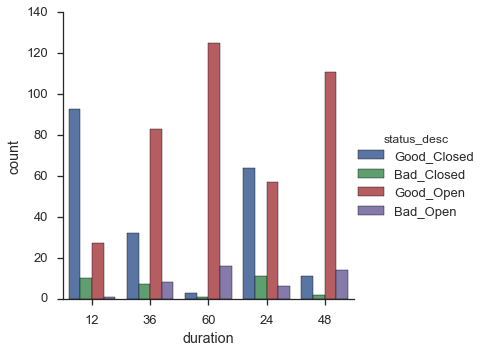

In [30]:
sns.set_context("talk")
sns.factorplot(x='duration',hue='status_desc',y=None,data=loan,kind='count',hue_order=['Good_Closed','Bad_Closed','Good_Open','Bad_Open'],size=5)
#,palette='Paired')

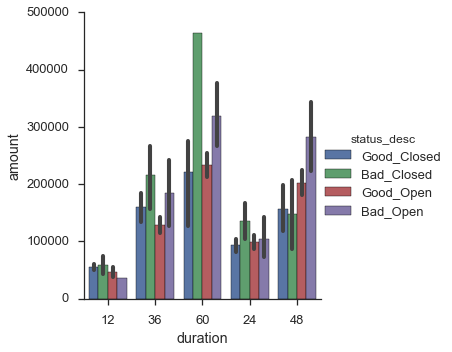

In [31]:
sns.factorplot(x='duration',hue='status_desc',y='amount',data=loan,kind='bar',hue_order=['Good_Closed','Bad_Closed','Good_Open','Bad_Open'],size=5)

In [32]:
loan_summary=pd.pivot_table(loan,values='amount',index=['status_desc'],columns=['duration'],aggfunc=[len,np.sum,np.mean],margins=True)

In [33]:
loan_summary

len                               sum                      \
duration      12   24   36   48   60  All       12        24        36   
status_desc                                                              
Bad_Closed    10   11    7    2    1   31   584256   1502016   1516212   
Bad_Open       1    6    8   14   16   45    36204    625032   1474380   
Good_Closed   93   64   32   11    3  203  5136444   5966688   5108508   
Good_Open     27   57   83  111  125  403  1269348   5598336  10627164   
All          131  138  130  138  145  682  7026252  13692072  18726264   

                                                    mean                 \
duration           48        60        All            12             24   
status_desc                                                               
Bad_Closed     295344    464520    4362348  58425.600000  136546.909091   
Bad_Open      3963408   5118780   11217804  36204.000000  104172.000000   
Good_Closed   1730016    661560   18603216  55230.580645   93229.500000   
Good_Open    22383024  29200500   69078372  47012.888889   98216.421053   
All          28371792  35445360  103261740  53635.000000   99217.000000   

                                                                     
duration                36             48         60            All  
status_desc                                                          
Bad_Closed   216601.714286  147672.000000  464520.00  140720.000000  
Bad_Open     184297.500000  283100.571429  319923.75  249284.000000  
Good_Closed  159640.875000  157274.181818  220520.00   91641.000000  
Good_Open    128038.120482  201648.864865  233604.00  171410.000000  
All          144048.000000  205592.000000  244450.00  151410.175953

In [34]:
loan['loan_id'].nunique()

682

### Wire and Cash Transactions Analysis:

In [35]:
txns_acct_loc=pd.merge(trans,account[['account_id','district_id']],on='account_id',how='left').rename(columns={'district_id':'acct_dist_id'})
#txns_location=pd.merge(txns_acct_loc,client[['client_id','district_id']],on='client_id',how='left')

In [36]:
cash_txns=txns_acct_loc[txns_acct_loc['operation'].isin(['VKLAD','VYBER'])]
#cash_txns[cash_txns['amount']>=10000]


In [37]:
cash_txns_93=cash_txns[cash_txns['date'].dt.year==1993]
len(cash_txns_93)



16447

In [38]:
cash_txns['date'].dt.year.unique()


array([1993, 1994, 1995, 1996, 1997, 1998])

In [39]:
cash_txns['year']=cash_txns['date'].dt.year

In [40]:
dist_sums=cash_txns_93[['acct_dist_id','amount']].groupby('acct_dist_id').aggregate({'amount':np.sum}).sort_values(['amount'],ascending=False)

dist_sums

,amount
acct_dist_id,
1,20468785.0
74,7848472.8
70,6438958.8
68,5703819.6
64,4839704.0
54,4619109.6
6,3485508.4
21,3451134.0
7,3396008.6


In [41]:
cash_txns.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,acct_dist_id,year
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700,700,NaN,NaN,NaN,16,1993
1,171812,576,1993-01-01,PRIJEM,VKLAD,900,900,NaN,NaN,NaN,55,1993
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN,55,1993
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600,600,NaN,NaN,NaN,74,1993
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400,400,NaN,NaN,NaN,77,1993


In [42]:
len(cash_txns)

591661

In [43]:
cash_txns_10k=cash_txns[cash_txns['amount']>=10000]

In [44]:
len(cash_txns_10k)

175662

In [45]:
cash_txns_25k=cash_txns[cash_txns['amount']>=25000]

In [46]:
len(cash_txns_25k)

44231

In [47]:
cash_aggs_25k=cash_txns_25k[['account_id','trans_id','amount','year']].groupby(['year','account_id'],as_index=False).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})

#.sort_values(by=['year','amount','trans_id'],ascending=[True,False,False])

#cash_aggs=cash_aggs.rename(columns={'amo'})

In [48]:
cash_aggs_25k.head()

year account_id trans_id amount              
                    nunique    sum   mean    max
0  1993         15        1  25598  25598  25598
1  1993         23        2  66264  33132  33132
2  1993         33        2  62384  31192  35384
3  1993         34        1  33000  33000  33000
4  1993         36        1  29778  29778  29778

In [49]:
cash_aggs_25k.columns=cash_aggs_25k.columns.map('_'.join)

cash_aggs_25k=cash_aggs_25k.rename(columns={'trans_id_nunique':'n_txns','amount_sum':'total_value','amount_mean':'mean_value','amount_max':'max_value'})

In [50]:
cash_aggs_25k.head()

,year_,account_id_,n_txns,total_value,mean_value,max_value
0,1993,15,1,25598,25598,25598
1,1993,23,2,66264,33132,33132
2,1993,33,2,62384,31192,35384
3,1993,34,1,33000,33000,33000
4,1993,36,1,29778,29778,29778


In [51]:
len(cash_aggs_25k)

7455

In [52]:
cash_25k_max=cash_aggs_25k.groupby('year_',as_index=False).\
aggregate({'account_id_':pd.Series.nunique,'n_txns':max,'total_value':max,'mean_value':max,'max_value':max}).\
rename(columns={'account_id_':'n_accts_25k','n_txns':'max_n_txns','total_value':'max_total_value','mean_value':'max_mean_value'})

In [53]:
cash_25k_max

,year_,max_total_value,max_value,max_n_txns,n_accts_25k,max_mean_value
0,1993,1040081,76500,28,409,56400
1,1994,1500968,72600,38,639,49556
2,1995,1323179,80400,33,913,52000
3,1996,1649693,86400,41,1467,70800
4,1997,1430541,80700,36,1954,57300
5,1998,1378855,87400,35,2073,72950


In [54]:
len(account)

4500

In [55]:
cash_txns_50k=cash_txns[cash_txns['amount']>=50000]

In [56]:
len(cash_txns_50k)

2623

In [57]:
cash_txns_50k['account_id'].nunique()

797

In [58]:
cash_aggs_50k=cash_txns_50k[['account_id','trans_id','amount','year']].groupby(['year','account_id'],as_index=False).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})

In [59]:
cash_aggs_50k.head()

year account_id trans_id  amount              
                    nunique     sum   mean    max
0  1993         47        1   63300  63300  63300
1  1993         96        1   62900  62900  62900
2  1993        212        1   58900  58900  58900
3  1993        239        2  125500  62750  63200
4  1993        456        3  166200  55400  63900

In [60]:
cash_aggs_50k.columns=cash_aggs_50k.columns.map('_'.join)

cash_aggs_50k=cash_aggs_50k.rename(columns={'trans_id_nunique':'n_txns','amount_sum':'total_value','amount_mean':'mean_value','amount_max':'max_value'})

In [61]:
cash_aggs_50k.head()

,year_,account_id_,n_txns,total_value,mean_value,max_value
0,1993,47,1,63300,63300,63300
1,1993,96,1,62900,62900,62900
2,1993,212,1,58900,58900,58900
3,1993,239,2,125500,62750,63200
4,1993,456,3,166200,55400,63900


In [62]:
cash_50k_max=cash_aggs_50k.groupby('year_',as_index=False).\
aggregate({'account_id_':pd.Series.nunique,'n_txns':max,'total_value':max,'mean_value':max,'max_value':max}).\
rename(columns={'account_id_':'n_accts_50k','n_txns':'max_n_txns','total_value':'max_total_value','mean_value':'max_mean_value'})

In [63]:
cash_50k_max

,year_,max_total_value,max_value,max_n_txns,n_accts_50k,max_mean_value
0,1993,281400,76500,5,69,64600
1,1994,290300,72600,5,109,66300
2,1995,289400,80400,5,164,78900
3,1996,359300,86400,6,262,86400
4,1997,473600,80700,8,416,80700
5,1998,401100,87400,7,476,85800


In [64]:
cash_txns_50k[cash_txns_50k['year']==1993]['account_id'].nunique()

69

In [65]:
cash_aggs_50k['account_id_'].nunique()

797

In [66]:
txns_acct_loc['operation'].unique()

array(['VKLAD', 'PREVOD Z UCTU', 'VYBER', nan, 'PREVOD NA UCET',
       'VYBER KARTOU'], dtype=object)

In [67]:
wire_txns=txns_acct_loc[txns_acct_loc['operation'].isin(['PREVOD Z UCTU','PREVOD NA UCET'])]

In [68]:
wire_txns['year']=wire_txns['date'].dt.year

In [69]:
len(wire_txns)

273509

In [70]:
wire_txns_50k=wire_txns[wire_txns['amount']>=50000]

In [71]:
len(wire_txns_50k)

1233

In [72]:
wire_txns_50k['account_id'].nunique()

170

In [73]:
wire_aggs_50k=wire_txns_50k[['account_id','trans_id','amount','year']].groupby(['year','account_id'],as_index=False).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})

In [74]:
wire_aggs_50k.columns=wire_aggs_50k.columns.map('_'.join)

wire_aggs_50k=wire_aggs_50k.rename(columns={'trans_id_nunique':'n_txns','amount_sum':'total_value','amount_mean':'mean_value','amount_max':'max_value'})

In [75]:
wire_aggs_50k.head()

,year_,account_id_,n_txns,total_value,mean_value,max_value
0,1993,47,1,52886,52886,52886
1,1993,66,1,67070,67070,67070
2,1993,96,2,132664,66332,66332
3,1993,212,2,148770,74385,74385
4,1993,222,2,103228,51614,51614


In [76]:
wire_50k_max=wire_aggs_50k.groupby('year_',as_index=False).\
aggregate({'account_id_':pd.Series.nunique,'n_txns':max,'total_value':max,'mean_value':max,'max_value':max}).\
rename(columns={'account_id_':'n_accts_50k','n_txns':'max_n_txns','total_value':'max_total_value','mean_value':'max_mean_value'})

In [77]:
wire_50k_max

,year_,max_total_value,max_value,max_n_txns,n_accts_50k,max_mean_value
0,1993,149296,74648,2,39,74648
1,1994,149540,74770,2,60,74770
2,1995,149540,74770,2,86,74770
3,1996,149540,74812,2,136,74812
4,1997,149624,74812,2,169,74812
5,1998,149624,74812,2,170,74812


### Identifying Good and Bad Clients:

In [78]:
acct_cash_50k=list(cash_txns_50k['account_id'].unique())

In [79]:
acct_wire_50k=list(wire_txns_50k['account_id'].unique())

In [80]:
acct_bad_loans=list(bad_loans['account_id'].unique())

In [81]:
bad_accts=list(set(acct_bad_loans+acct_wire_50k+acct_cash_50k))

In [82]:
len(bad_accts)

872

In [83]:
client_acct_linked=pd.merge(client[['client_id','district_id']],disp[['disp_id','client_id','account_id']],on=['client_id'],how='left').rename(columns={'district_id':'client_dist_id'})

client_acct_linked=pd.merge(client_acct_linked,account[['account_id','district_id']],on=['account_id'],how='left').rename(columns={'district_id':'acct_dist_id'})

In [84]:
client_acct_linked.head()

,client_id,client_dist_id,disp_id,account_id,acct_dist_id
0,1,18,1,1,18
1,2,1,2,2,1
2,3,1,3,2,1
3,4,5,4,3,5
4,5,5,5,3,5


In [85]:
bad_dist_id=list(high_crime_rt_dist['district_id'].unique())

In [86]:
client_acct_linked['Good_Bad_Client']=client_acct_linked.apply(lambda x: 'BAD' if x['account_id'] in bad_accts or x['client_dist_id'] in bad_dist_id or x['acct_dist_id'] in bad_dist_id else 'GOOD',axis=1)

In [87]:
client_acct_linked.head()

,client_id,client_dist_id,disp_id,account_id,acct_dist_id,Good_Bad_Client
0,1,18,1,1,18,GOOD
1,2,1,2,2,1,BAD
2,3,1,3,2,1,BAD
3,4,5,4,3,5,GOOD
4,5,5,5,3,5,GOOD


In [88]:
len(client_acct_linked)

5369

In [89]:
client_acct_linked['Good_Bad_Client'].value_counts()

GOOD    3133
BAD     2236
Name: Good_Bad_Client, dtype: int64

### Predictive Modelling:

#### Data Preparation:

In [90]:
client_acct_features=pd.merge(client_acct_linked,loan[['account_id','status','status_desc']],on='account_id',how='left')

In [91]:
cash_ft_aggs_year=cash_txns[['account_id','trans_id','amount','year']].groupby(['year','account_id']).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})

In [92]:
cash_ft_aggs_year.head()

trans_id    amount                     
                 nunique       sum          mean    max
year account_id                                        
1993 2                29  169314.6   5838.434483  22400
     9                37   81511.8   2203.021622  14245
     15                7   88228.0  12604.000000  25598
     18                7   25300.0   3614.285714  13500
     23               20  298627.8  14931.390000  33132

In [93]:
cash_ft_aggs_year.unstack(level=0).head(20)

trans_id                             amount                       \
            nunique                                sum                        
year           1993 1994 1995 1996 1997 1998      1993       1994      1995   
account_id                                                                    
1               NaN  NaN   17   38   28   26       NaN        NaN   37283.0   
2                29   37   37   49   48   49  169314.6   131916.2  131889.2   
3               NaN  NaN  NaN  NaN   16   44       NaN        NaN       NaN   
4               NaN  NaN  NaN   12   30   21       NaN        NaN       NaN   
5               NaN  NaN  NaN  NaN    6   30       NaN        NaN       NaN   
6               NaN    1   23   27   25   25       NaN      900.0   24980.6   
7               NaN  NaN  NaN    3   36   45       NaN        NaN       NaN   
8               NaN  NaN    7   42   48   49       NaN        NaN  105162.0   
9                37   53   54   54   48   44   81511.8    99274.2  128164.2   
10              NaN  NaN  NaN    9   47   49       NaN        NaN       NaN   
11              NaN  NaN    1   14   27   31       NaN        NaN     300.0   
12              NaN  NaN  NaN  NaN   14   24       NaN        NaN       NaN   
13              NaN  NaN  NaN  NaN    3   31       NaN        NaN       NaN   
14              NaN  NaN  NaN    3   34   36       NaN        NaN       NaN   
15                7   41   49   50   50   46   88228.0   421106.6  407661.2   
16              NaN  NaN  NaN  NaN    7   38       NaN        NaN       NaN   
17              NaN  NaN  NaN  NaN   14   21       NaN        NaN       NaN   
18                7   60   33   51   71   46   25300.0  1210035.0  189370.0   
19              NaN  NaN   27   49   39   45       NaN        NaN  166281.0   
20              NaN  NaN  NaN    1   19   20       NaN        NaN       NaN   

                      ...                                              \
                      ...            mean                               
year            1996  ...            1995          1996          1997   
account_id            ...                                               
1            31255.2  ...     2193.117647    822.505263    789.828571   
2           210882.2  ...     3564.572973   4303.718367   4379.191667   
3                NaN  ...             NaN           NaN   5247.012500   
4            14677.6  ...             NaN   1223.133333   1078.506667   
5                NaN  ...             NaN           NaN    608.966667   
6            34355.2  ...     1086.113043   1272.414815    873.408000   
7            41475.0  ...             NaN  13825.000000  14431.705556   
8           444754.6  ...    15023.142857  10589.395238   8661.441667   
9           101809.2  ...     2373.411111   1885.355556   3381.545833   
10          120187.0  ...             NaN  13354.111111   8227.514894   
11            1420.6  ...      300.000000    101.471429    332.414815   
12               NaN  ...             NaN           NaN    984.171429   
13               NaN  ...             NaN           NaN   2133.333333   
14           24737.0  ...             NaN   8245.666667  10052.511765   
15          418361.2  ...     8319.616327   8367.224000   8103.224000   
16               NaN  ...             NaN           NaN  15963.428571   
17               NaN  ...             NaN           NaN  12689.714286   
18          483260.0  ...     5738.484848   9475.686275  17318.450704   
19          236863.1  ...     6158.555556   4833.940816   5304.492308   
20             500.0  ...             NaN    500.000000    373.431579   

                                                                    
                            max                                     
year                1998   1993   1994   1995   1996   1997   1998  
account_id                                                          
1             685.407692    NaN    NaN  12600   3700   4700   6500  
2            398

In [94]:
cash_ft_aggs=cash_txns[['account_id','trans_id','amount']].groupby(['account_id'],as_index=False).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})

cash_ft_aggs.columns=cash_ft_aggs.columns.map('_'.join)

In [95]:
cash_ft_aggs.head()

,account_id_,trans_id_nunique,amount_sum,amount_mean,amount_max
0,1,109,108474.0,995.174312,12600
1,2,249,1049591.0,4215.224900,42000
2,3,60,227938.8,3798.980000,11253
3,4,63,60613.4,962.117460,5250
4,5,36,32644.4,906.788889,5100


In [96]:
cash_ft_aggs_25k=cash_txns_25k[['account_id','trans_id','amount']].groupby(['account_id'],as_index=False).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})
cash_ft_aggs=cash_ft_aggs.rename(columns={'account_id_':'account_id'})

cash_ft_aggs_25k.columns=cash_ft_aggs_25k.columns.map('_'.join)
cash_ft_aggs_25k=cash_ft_aggs_25k.add_suffix('_25k')
cash_ft_aggs_25k=cash_ft_aggs_25k.rename(columns={'account_id__25k':'account_id'})

cash_ft_aggs_50k=cash_txns_50k[['account_id','trans_id','amount']].groupby(['account_id'],as_index=False).\
aggregate({'amount':[np.sum,np.mean,max],'trans_id':pd.Series.nunique})

cash_ft_aggs_50k.columns=cash_ft_aggs_50k.columns.map('_'.join)
cash_ft_aggs_50k=cash_ft_aggs_50k.add_suffix('_50k')
cash_ft_aggs_50k=cash_ft_aggs_50k.rename(columns={'account_id__50k':'account_id'})

In [97]:
cash_ft_aggs_50k.head()

,account_id,trans_id_nunique_50k,amount_sum_50k,amount_mean_50k,amount_max_50k
0,18,6,347000,57833.333333,70200
1,25,7,405300,57900.000000,63300
2,30,7,427200,61028.571429,75600
3,31,2,115300,57650.000000,61700
4,33,1,63100,63100.000000,63100


In [98]:
client_acct_features=pd.merge(client_acct_features,cash_ft_aggs,on=['account_id'],how='left')
client_acct_features=pd.merge(client_acct_features,cash_ft_aggs_25k,on=['account_id'],how='left')
client_acct_features=pd.merge(client_acct_features,cash_ft_aggs_50k,on=['account_id'],how='left')

In [99]:
client_acct_features.loc[:,'amount_sum':]=client_acct_features.loc[:,'amount_sum':].fillna(0)

In [100]:
client_acct_features.head()

,client_id,client_dist_id,disp_id,account_id,acct_dist_id,Good_Bad_Client,status,status_desc,trans_id_nunique,amount_sum,amount_mean,amount_max,trans_id_nunique_25k,amount_sum_25k,amount_mean_25k,amount_max_25k,trans_id_nunique_50k,amount_sum_50k,amount_mean_50k,amount_max_50k
0,1,18,1,1,18,GOOD,NaN,NaN,109,108474.0,995.174312,12600,0,0,0,0,0,0,0,0
1,2,1,2,2,1,BAD,A,Good_Closed,249,1049591.0,4215.224900,42000,1,42000,42000,42000,0,0,0,0
2,3,1,3,2,1,BAD,A,Good_Closed,249,1049591.0,4215.224900,42000,1,42000,42000,42000,0,0,0,0
3,4,5,4,3,5,GOOD,NaN,NaN,60,227938.8,3798.980000,11253,0,0,0,0,0,0,0,0
4,5,5,5,3,5,GOOD,NaN,NaN,60,227938.8,3798.980000,11253,0,0,0,0,0,0,0,0


In [101]:
X=client_acct_features[[x for x in list(client_acct_features.columns) if x not in ['client_id','status_desc','disp_id','account_id','Good_Bad_Client']]]

In [102]:
Y=client_acct_features['Good_Bad_Client']

#### SVM:

In [103]:
svm_x_scaled=X.copy()
svm_x_scaled.loc[:,'amount_sum':]=preprocessing.scale(svm_x_scaled.loc[:,'amount_sum':])

svm_x_scaled_encoded=pd.get_dummies(svm_x_scaled,columns=['client_dist_id','acct_dist_id','status'])

In [104]:
svm_x_scaled_encoded.head()

,trans_id_nunique,amount_sum,amount_mean,amount_max,trans_id_nunique_25k,amount_sum_25k,amount_mean_25k,amount_max_25k,trans_id_nunique_50k,amount_sum_50k,...,acct_dist_id_72,acct_dist_id_73,acct_dist_id_74,acct_dist_id_75,acct_dist_id_76,acct_dist_id_77,status_A,status_B,status_C,status_D
0,109,-0.805123,-1.108146,-0.808782,-0.515353,-0.494840,-0.983188,-0.916830,-0.353431,-0.353485,...,0,0,0,0,0,0,0,0,0,0
1,249,0.009773,-0.501835,0.693573,-0.461561,-0.435393,1.443406,0.802267,-0.353431,-0.353485,...,0,0,0,0,0,0,1,0,0,0
2,249,0.009773,-0.501835,0.693573,-0.461561,-0.435393,1.443406,0.802267,-0.353431,-0.353485,...,0,0,0,0,0,0,1,0,0,0
3,60,-0.701681,-0.580211,-0.877614,-0.515353,-0.494840,-0.983188,-0.916830,-0.353431,-0.353485,...,0,0,0,0,0,0,0,0,0,0
4,60,-0.701681,-0.580211,-0.877614,-0.515353,-0.494840,-0.983188,-0.916830,-0.353431,-0.353485,...,0,0,0,0,0,0,0,0,0,0


In [105]:
np.std(svm_x_scaled_encoded['trans_id_nunique_25k'])

1.0

In [106]:
y_label_enc=preprocessing.LabelEncoder()
Y_encoded=pd.Series(y_label_enc.fit_transform(Y))

In [107]:
Y_encoded.head()

0    1
1    0
2    0
3    1
4    1
dtype: int64

##### SVM with features from Txns > 50k:

In [108]:
SVM_clf_50k=SVC()


SVM_50k_cols=[x for x in list(svm_x_scaled_encoded.columns)\
              if x not in ['amount_sum','amount_mean','amount_max','trans_id_nunique',\
                          'amount_sum_25k','amount_mean_25k','amount_max_25k','trans_id_nunique_25k']]

X_train_SVM_50k, X_test_SVM_50k, y_train_SVM_50k,\
y_test_SVM_50k = train_test_split(svm_x_scaled_encoded[SVM_50k_cols],Y_encoded,train_size=0.75)

#[SVM_50k_cols]

SVM_clf_50k.fit(X_train_SVM_50k,y_train_SVM_50k)
SVM_50k_accuracy=SVM_clf_50k.score(X_test_SVM_50k,y_test_SVM_50k)
print('Accuracy of SVM using features from txn > 50k: {} %'.format(round(SVM_50k_accuracy*100,2)))

Accuracy SVM using features from txn > 50k: 93.37 %


##### SVM with features from Txns > 25k:

In [109]:
SVM_clf_25k=SVC()


SVM_25k_cols=[x for x in list(svm_x_scaled_encoded.columns)\
              if x not in ['amount_sum','amount_mean','amount_max','trans_id_nunique',\
                          'amount_sum_50k','amount_mean_50k','amount_max_50k','trans_id_nunique_50k']]

X_train_SVM_25k, X_test_SVM_25k, y_train_SVM_25k,\
y_test_SVM_25k = train_test_split(svm_x_scaled_encoded[SVM_25k_cols],Y_encoded,train_size=0.75)

#[SVM_50k_cols]

SVM_clf_25k.fit(X_train_SVM_25k,y_train_SVM_25k)
SVM_25k_accuracy=SVM_clf_25k.score(X_test_SVM_25k,y_test_SVM_25k)
print('Accuracy of SVM using features from txn > 25k: {} %'.format(round(SVM_25k_accuracy*100,2)))

Accuracy SVM using features from txn > 25k: 89.95 %


##### SVM with features from All Txns:

In [110]:
SVM_clf_all=SVC()


SVM_all_cols=[x for x in list(svm_x_scaled_encoded.columns)\
              if x not in ['amount_sum_25k','amount_mean_25k','amount_max_25k','trans_id_nunique_25k',\
                          'amount_sum_50k','amount_mean_50k','amount_max_50k','trans_id_nunique_50k']]

X_train_SVM_all, X_test_SVM_all, y_train_SVM_all,\
y_test_SVM_all = train_test_split(svm_x_scaled_encoded[SVM_all_cols],Y_encoded,train_size=0.75)

#[SVM_50k_cols]

SVM_clf_all.fit(X_train_SVM_all,y_train_SVM_all)
SVM_all_accuracy=SVM_clf_all.score(X_test_SVM_all,y_test_SVM_all)
print('Accuracy of SVM using features from all txns: {} %'.format(round(SVM_all_accuracy*100,2)))

Accuracy SVM using features from all txns: 78.11 %


#### Decision Tree:

In [112]:
dtc_x_encoded=X
dtc_x_encoded.loc[:,['client_dist_id','acct_dist_id','status']].head()
dtc_x_encoded.loc[:,['client_dist_id','acct_dist_id','status']]=dtc_x_encoded.\
loc[:,['client_dist_id','acct_dist_id','status']].fillna('NULL').apply(preprocessing.LabelEncoder().fit_transform)

dtc_x_encoded.head()

,client_dist_id,acct_dist_id,status,trans_id_nunique,amount_sum,amount_mean,amount_max,trans_id_nunique_25k,amount_sum_25k,amount_mean_25k,amount_max_25k,trans_id_nunique_50k,amount_sum_50k,amount_mean_50k,amount_max_50k
0,17,17,4,109,108474.0,995.174312,12600,0,0,0,0,0,0,0,0
1,0,0,0,249,1049591.0,4215.224900,42000,1,42000,42000,42000,0,0,0,0
2,0,0,0,249,1049591.0,4215.224900,42000,1,42000,42000,42000,0,0,0,0
3,4,4,4,60,227938.8,3798.980000,11253,0,0,0,0,0,0,0,0
4,4,4,4,60,227938.8,3798.980000,11253,0,0,0,0,0,0,0,0


In [113]:
dtc_x_encoded.dtypes

client_dist_id            int64
acct_dist_id              int64
status                    int64
trans_id_nunique          int64
amount_sum              float64
amount_mean             float64
amount_max              float64
trans_id_nunique_25k    float64
amount_sum_25k          float64
amount_mean_25k         float64
amount_max_25k          float64
trans_id_nunique_50k    float64
amount_sum_50k          float64
amount_mean_50k         float64
amount_max_50k          float64
dtype: object

##### Decision Tree with features from Txns > 50k:

In [114]:
DTC_clf_50k=tree.DecisionTreeClassifier()


DTC_50k_cols=[x for x in list(dtc_x_encoded.columns)\
              if x not in ['amount_sum','amount_mean','amount_max','trans_id_nunique',\
                          'amount_sum_25k','amount_mean_25k','amount_max_25k','trans_id_nunique_25k']]

X_train_DTC_50k, X_test_DTC_50k, y_train_DTC_50k,\
y_test_DTC_50k = train_test_split(dtc_x_encoded[DTC_50k_cols],Y_encoded,train_size=0.75)

#[SVM_50k_cols]

DTC_clf_50k.fit(X_train_DTC_50k,y_train_DTC_50k)
DTC_50k_accuracy=DTC_clf_50k.score(X_test_DTC_50k,y_test_DTC_50k)
print('Accuracy of Decision Tree using features from txn > 50k: {} %'.format(round(DTC_50k_accuracy*100,2)))

Accuracy of Decision Tree using features from txn > 50k: 98.73 %


##### Decision Tree with features from Txns > 25k:

In [115]:
DTC_clf_25k=tree.DecisionTreeClassifier()


DTC_25k_cols=[x for x in list(dtc_x_encoded.columns)\
              if x not in ['amount_sum','amount_mean','amount_max','trans_id_nunique',\
                          'amount_sum_50k','amount_mean_50k','amount_max_50k','trans_id_nunique_50k']]

X_train_DTC_25k, X_test_DTC_25k, y_train_DTC_25k,\
y_test_DTC_25k = train_test_split(dtc_x_encoded[DTC_25k_cols],Y_encoded,train_size=0.75)

#[SVM_50k_cols]

DTC_clf_25k.fit(X_train_DTC_25k,y_train_DTC_25k)
DTC_25k_accuracy=DTC_clf_25k.score(X_test_DTC_25k,y_test_DTC_25k)
print('Accuracy of Decision Tree using features from txn > 25k: {} %'.format(round(DTC_25k_accuracy*100,2)))

Accuracy of Decision Tree using features from txn > 25k: 98.14 %


##### Decision Tree with features from All Txns:

In [116]:
DTC_clf_all=tree.DecisionTreeClassifier()


DTC_all_cols=[x for x in list(dtc_x_encoded.columns)\
              if x not in ['amount_sum_25k','amount_mean_25k','amount_max_25k','trans_id_nunique_25k',\
                          'amount_sum_50k','amount_mean_50k','amount_max_50k','trans_id_nunique_50k']]

X_train_DTC_all, X_test_DTC_all, y_train_DTC_all,\
y_test_DTC_all = train_test_split(dtc_x_encoded[DTC_all_cols],Y_encoded,train_size=0.75)

#[SVM_50k_cols]

DTC_clf_all.fit(X_train_DTC_all,y_train_DTC_all)
DTC_all_accuracy=DTC_clf_all.score(X_test_DTC_all,y_test_DTC_all)
print('Accuracy of Decision Tree using features from all txns: {} %'.format(round(DTC_all_accuracy*100,2)))

Accuracy of Decision Tree using features from all txns: 98.66 %


## Conclusion:

For this predictive modelling/descriptive analysis exercise, a **realistic** data set, with characteristics which one might encounter in AML data, was chosen. Part of the task was to analyze the data to determine whether a client is Good or Bad. By analyzing the data and making choices of metrics based on AML experience, these clients were identified.

The second part of this exercise was predictive modelling. For this, a classifer to determine Good and Bad clients from the original data set was to be designed. The author trained Support Vector and Decision Tree classifers. For each class of classifer, three sets of training data, differing only in the transaction features, were used. One set had transaction features of cash and wire transactions > 50k in value, another had features of cash and wire transactions > 25k in value, and the third had features of all cash and wire transactions.

It was found that as a class, the Decision Tree Classifier performed better than SVM with peak accuracies around 98% for all 3 feature sets. The SVM performed best for features of transactions >50k with accuracies around 93%. The SVM classifiers for features from >25k transactions and all transactions were around 90% and 79% respectively.